<a href="https://colab.research.google.com/github/kkb0318/benkyokai/blob/main/bayesCaseStudy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考：https://docs.pymc.io/pymc-examples/examples/case_studies/putting_workflow.html

## ライブラリインポート

In [1]:
!pip install arviz==0.10.0
!pip install --upgrade pymc3==3.8

     |████████████████████████████████| 1.5MB 3.6MB/s 
     |████████████████████████████████| 808kB 8.0MB/s 
     |████████████████████████████████| 4.7MB 13.0MB/s 
     |████████████████████████████████| 317kB 39.3MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
     |████████████████████████████████| 911kB 2.8MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [2]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as st

print(f"Running on PyMC3 v{pm.__version__}")
np.random.seed(seed=10)

Running on PyMC3 v3.8


In [3]:
plt.rcParams.update(
    {
        "axes.prop_cycle": plt.cycler(
            "color",
            [
                "#000000",
                "#1b6989",
                "#e69f00",
                "#009e73",
                "#f0e442",
                "#50b4e9",
                "#d55e00",
                "#cc79a7",
            ],
        ),
        "figure.figsize": [12.0, 5.0],
        "font.serif": [
            "Palatino",
            "Palatino Linotype",
            "Palatino LT STD",
            "Book Antiqua",
            "Georgia",
            "DejaVu Serif",
        ],
        "font.family": "serif",
        "figure.facecolor": "#fffff8",
        "figure.constrained_layout.use": True,
        "font.size": 14.0,
        "hist.bins": "auto",
        "lines.linewidth": 3.0,
        "lines.markeredgewidth": 2.0,
        "lines.markerfacecolor": "none",
        "lines.markersize": 8.0,
    }
)

## データ

### お試し学習用データ

“Statistics: A Bayesian Perspective”, by Don Berry (1995).  https://mc-stan.org/users/documentation/case-studies/golf.html


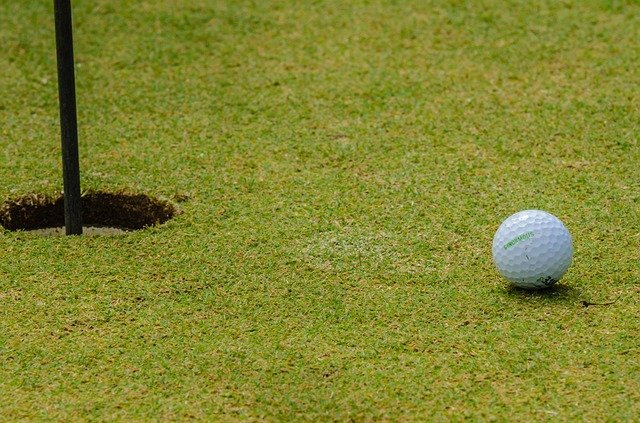

パットの成功確率を予測しよう！

与えられているデータは以下のとおり

In [4]:
# golf putting data from berry (1996)
# カップまでの距離　パット数　成功数
golf_data = """distance tries successes
2 1443 1346
3 694 577
4 455 337
5 353 208
6 272 149
7 256 136
8 240 111
9 217 69
10 200 67
11 237 75
12 202 52
13 192 46
14 174 54
15 167 28
16 201 27
17 195 31
18 191 33
19 147 20
20 152 24"""


golf_data = pd.read_csv(io.StringIO(golf_data), sep=" ")

とりあえずデータを見てみる

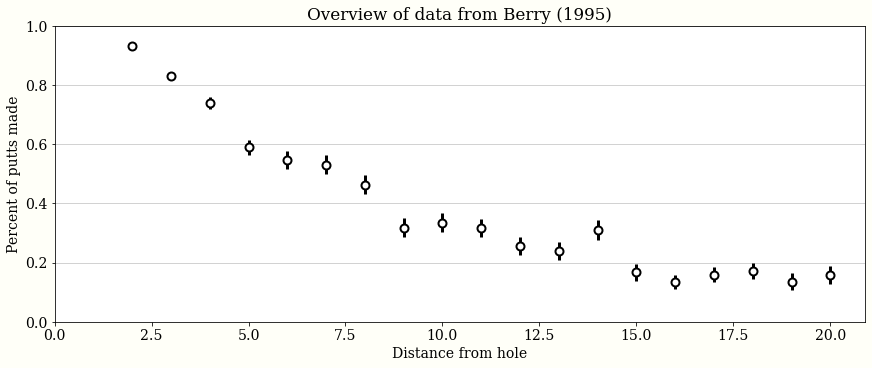

In [5]:
def plot_golf_data(golf_data, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    bg_color = ax.get_facecolor()

    '''
      beta分布(成功, 失敗)　⇦試行数が多ければ不確実性も小さい

　　　　　　　　　　例：コインの裏表
　　　　　　　　　　　　　　　試行：３回　→　表２回、裏１回　→ 66%の確率で表がでるコイン！！・・・試行数が少ないので不確実性が高い
　　　　　　　　　　　　　　　試行：100回　→　表52回、裏48回　→ 52%の確率で表がでるコイン！！・・・試行数が多いので不確実性が小さい
    '''
    rv = st.beta(golf_data.successes, golf_data.tries - golf_data.successes)
    ax.vlines(golf_data.distance, *rv.interval(0.68), label=None) # rv.interval:  return (y.min[],y.max[])    68%信頼区間
    ax.plot(
        golf_data.distance, golf_data.successes / golf_data.tries, "o", mfc=bg_color, label=None
    )

    ax.set_xlabel("Distance from hole")
    ax.set_ylabel("Percent of putts made")
    ax.set_ylim(bottom=0, top=1)

    ax.set_xlim(left=0)
    ax.grid(True, axis="y", alpha=0.7)
    return ax


ax = plot_golf_data(golf_data)
ax.set_title("Overview of data from Berry (1995)");

## モデル１

### 二項分布のロジスティックモデル

**パットの成功確率の予測モデルを定義**

パットの成功確率　＝　a * カップまでの距離 + b

a,b　： 正規分布と仮定

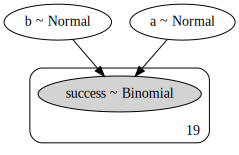

In [6]:
def logit_model(golf_data):
    with pm.Model() as logit_binomial:
        a = pm.Normal("a")
        b = pm.Normal("b")
        # 二項分布
        success = pm.Binomial(
            "success",
            n=golf_data.tries,
            p=pm.math.invlogit(a * golf_data.distance + b),
            observed=golf_data.successes,
        )
    return logit_binomial


pm.model_to_graphviz(logit_model(golf_data))

In [7]:
# モデルの学習
with logit_model(golf_data):
    logit_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1006.55it/s]
The number of effective samples is smaller than 25% for some parameters.


In [8]:
# ポイントは、a, b どちらも「値」ではなく「確率分布」として得られること
pm.summary(logit_trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.255,0.007,-0.268,-0.241,0.000,0.000,447.0,447.0,448.0,568.0,1.0
b,2.226,0.062,2.107,2.337,0.003,0.002,457.0,457.0,454.0,753.0,1.0


|項目|意味|
|---|---|
|mean|平均|
|sd|標準偏差|
|hdi_3%|データが3%存在する区間|
|hdi_97%|97%存在する区間|
|mcse_mean|モンテカルロ標準誤差の平均値|
|mcse_sd|モンテカルロ標準誤差の標準偏差|
|ess_mean|有効サンプルサイズの平均値|
|ess_sd|有効サンプルサイズの標準偏差|
|ess_bulk|ランク正規化された有効サンプルサイズ|
|ess_tail|95%分位点での有効サンプルサイズ|
|r_hat|Gelman-Rubin統計量（収束判断の指標のひとつ）。1.1以下であればまあよし|

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 333.22it/s]


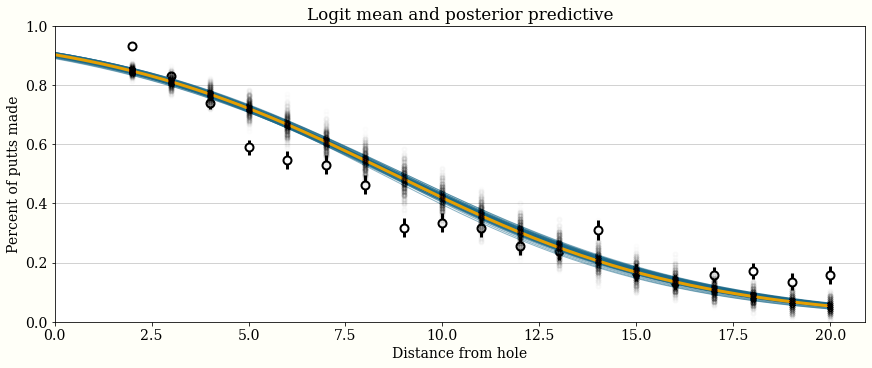

In [9]:
# Draw posterior predictive samples
with logit_model(golf_data):
    # ５００以上のプロットはみづらいので500に制限
    # logit_ppc["success"].shape = (500,19) データ点ごとに500個の推論値を出力
    logit_ppc = pm.sample_posterior_predictive(logit_trace, samples=500)

logit_ppc_success = logit_ppc["success"].T / golf_data.tries.values.reshape(-1, 1)

# プロット
ax = plot_golf_data(golf_data)
t = np.linspace(0, golf_data.distance.max(), 200)

for idx in np.random.randint(0, len(logit_trace), 50):
    ax.plot(
        t,
        scipy.special.expit(logit_trace["a"][idx] * t + logit_trace["b"][idx]),
        lw=1,
        color="C1",
        alpha=0.5,
    )

# t(カップまでの距離)-sigmoid(p(a|x)*distance + p(b|x)).mean
# 推論結果の平均値 ？
ax.plot(
    t,
    scipy.special.expit(logit_trace["a"].reshape(-1, 1) * t + logit_trace["b"].reshape(-1, 1)).mean(
        axis=0
    ),
    color="C2",
)

ax.plot(golf_data.distance, logit_ppc_success, "k.", alpha=0.01)
ax.set_title("Logit mean and posterior predictive");

### ジオメトリベースのモデル

目的：
* 実データへのフィットの向上
* 外挿の信頼性向上

考え方：

ゴルファーがパッティングをするときはカップの中心を狙うが、実際は少し角度がずれてしまう(角度にばらつき　variance:分散　がある)

カップの領域内にゴルフボールが収まればカップインすると仮定し、カップ径(CUP_RADIUS)とボール径(BALL_RADIUS)から、角度のずれがどの程度まで許容されるかがわかる

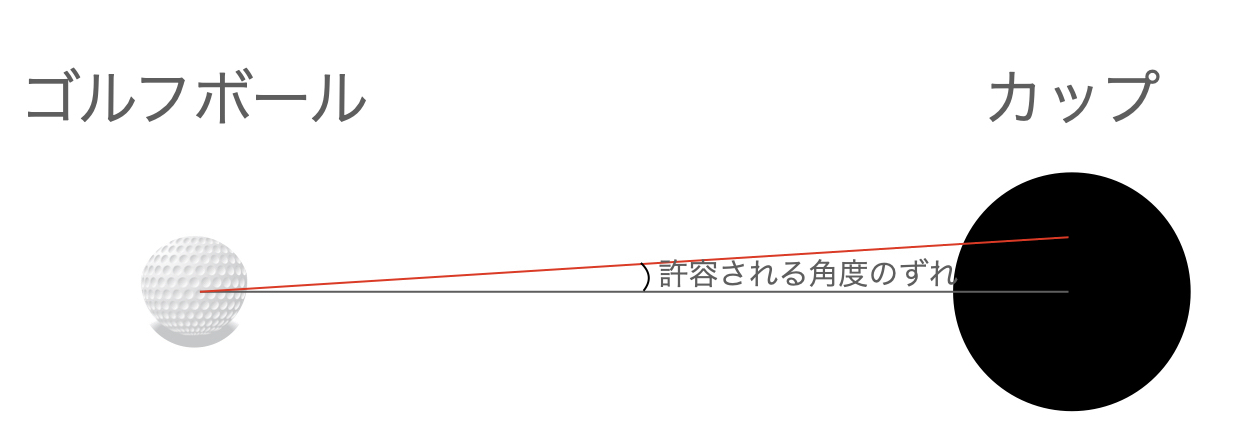

許容される最大角：arcsin((CUP_RADIUS-BALL_RADIUS)/距離)

パットの角度：N(0, variance)

→パットの角度が、許容される最大角の中に収まる確率は 2*f(θ)-1   (f:N(0,variance)の累積分布関数, θ：許容される最大角)

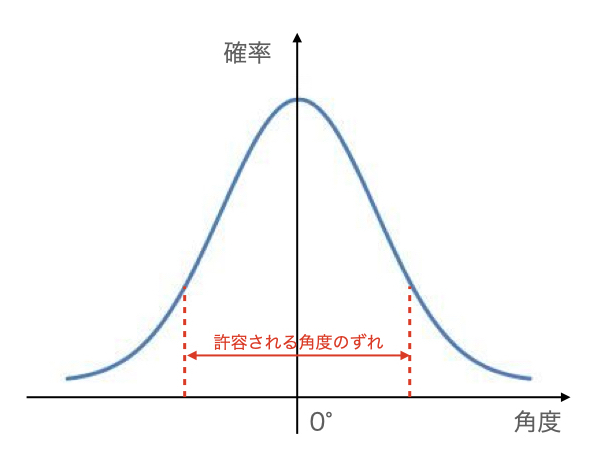

関数を作ってとりあえずいろんなvariance(角度のずれのばらつき)を入れてプロットしてみると・・・

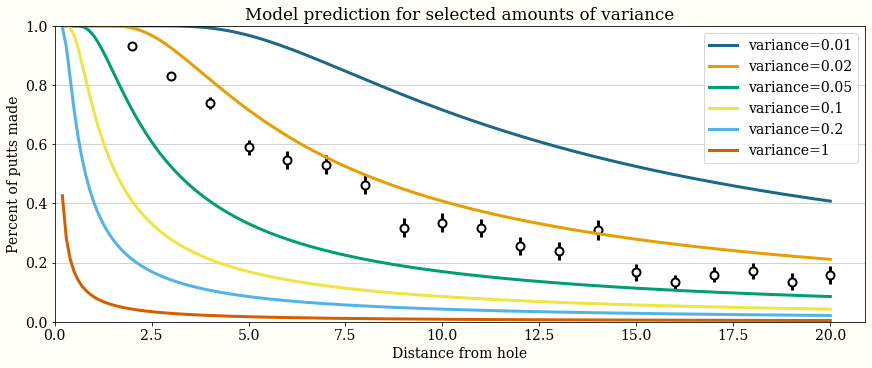

In [11]:
BALL_RADIUS = (1.68 / 2) / 12
CUP_RADIUS = (4.25 / 2) / 12

# 上図の赤い範囲内の確率の式
def forward_angle_model(variance_of_shot, t):
    return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1


ax = plot_golf_data(golf_data)

t = np.linspace(0, golf_data.distance.max(), 200)

for variance_of_shot in (0.01, 0.02, 0.05, 0.1, 0.2, 1):
    ax.plot(t, forward_angle_model(variance_of_shot, t), label=f"variance={variance_of_shot}")
ax.set_title("Model prediction for selected amounts of variance")
ax.legend();

variance=0.02 あたりで実データにそこそこフィットできているので、この角度モデルでうまく表現できそう。

#### モデル作成

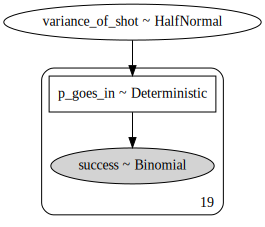

In [12]:
import theano.tensor as tt


def Phi(x):
    """Calculates the standard normal cumulative distribution function."""
    return 0.5 + 0.5 * tt.erf(x / tt.sqrt(2.0))


def angle_model(golf_data):
    with pm.Model() as angle_model:
        variance_of_shot = pm.HalfNormal("variance_of_shot")
        p_goes_in = pm.Deterministic(
            "p_goes_in",
            2 * Phi(tt.arcsin((CUP_RADIUS - BALL_RADIUS) / golf_data.distance) / variance_of_shot)
            - 1,
        )
        success = pm.Binomial(
            "success", n=golf_data.tries, p=p_goes_in, observed=golf_data.successes
        )
    return angle_model


pm.model_to_graphviz(angle_model(golf_data))

モデル学習

In [13]:
with angle_model(golf_data):
    angle_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [variance_of_shot]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1600.89it/s]


最初に作ったモデル(y=ax+b)と比較してみる・・・

※事後分布も確率分布であるがわかりやすくするために平均値のみを青線・オレンジ線で描画

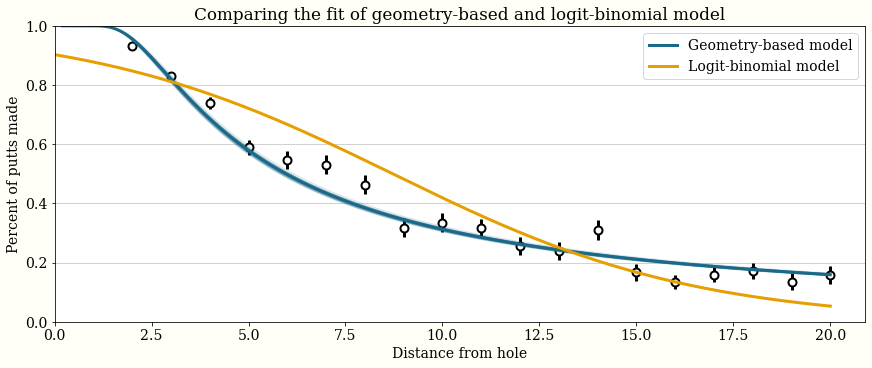

In [14]:
ax = plot_golf_data(golf_data)

t = np.linspace(0, golf_data.distance.max(), 200)

for idx in np.random.randint(0, len(angle_trace), 50):
    ax.plot(
        t, forward_angle_model(angle_trace["variance_of_shot"][idx], t), lw=1, color="C1", alpha=0.1
    )
ax.plot(
    t, forward_angle_model(angle_trace["variance_of_shot"].mean(), t), label="Geometry-based model"
)

ax.plot(
    t,
    scipy.special.expit(logit_trace["a"].mean() * t + logit_trace["b"].mean()),
    label="Logit-binomial model",
)
ax.set_title("Comparing the fit of geometry-based and logit-binomial model")
ax.legend();

より実データにフィットするモデル（青線）を構築できた！！

ジオメトリベースのモデルを図で表すと以下のようになる

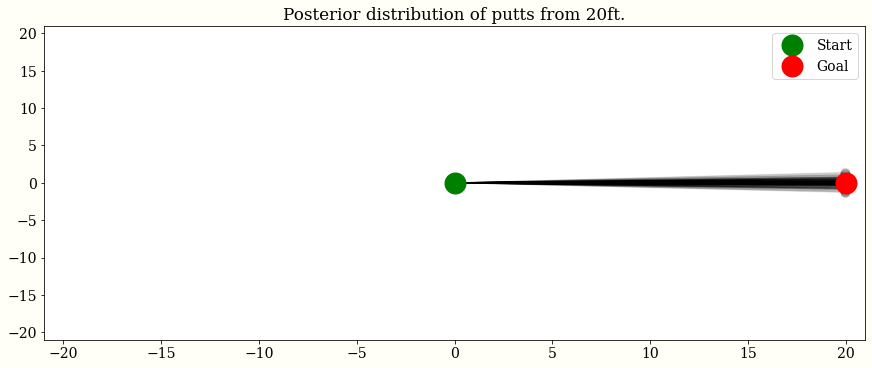

In [20]:
angle_of_shot = np.random.normal(
    0, np.random.choice(angle_trace["variance_of_shot"].flatten(), 500)
)  # radians
distance = 20  # feet

end_positions = np.array([distance * np.cos(angle_of_shot), distance * np.sin(angle_of_shot)])

fig, ax = plt.subplots()
for endx, endy in end_positions.T:
    ax.plot([0, endx], [0, endy], "k-o", lw=1, mfc="w", alpha=0.05)
ax.plot(0, 0, "go", label="Start", mfc="g", ms=20)
ax.plot(distance, 0, "ro", label="Goal", mfc="r", ms=20)

ax.set_xlim(-21, 21)
ax.set_ylim(-21, 21)
ax.set_title(f"Posterior distribution of putts from {distance}ft.")
ax.legend();

## new データ

より多様な距離のデータも含める

In [21]:
#  golf putting data from Broadie (2018)
new_golf_data = """distance tries successes
0.28 45198 45183
0.97 183020 182899
1.93 169503 168594
2.92 113094 108953
3.93 73855 64740
4.94 53659 41106
5.94 42991 28205
6.95 37050 21334
7.95 33275 16615
8.95 30836 13503
9.95 28637 11060
10.95 26239 9032
11.95 24636 7687
12.95 22876 6432
14.43 41267 9813
16.43 35712 7196
18.44 31573 5290
20.44 28280 4086
21.95 13238 1642
24.39 46570 4767
28.40 38422 2980
32.39 31641 1996
36.39 25604 1327
40.37 20366 834
44.38 15977 559
48.37 11770 311
52.36 8708 231
57.25 8878 204
63.23 5492 103
69.18 3087 35
75.19 1742 24"""

new_golf_data = pd.read_csv(io.StringIO(new_golf_data), sep=" ")

## モデル２

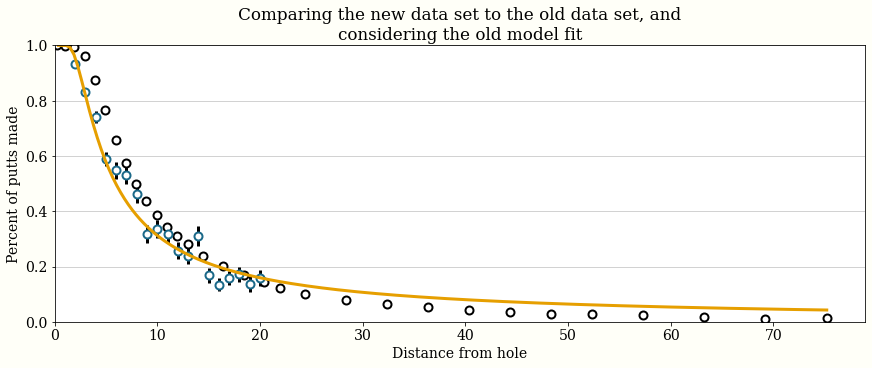

In [22]:
ax = plot_golf_data(new_golf_data)
plot_golf_data(golf_data, ax=ax)
t = np.linspace(0, new_golf_data.distance.max(), 200)

ax.plot(t, forward_angle_model(angle_trace["variance_of_shot"].mean(), t))
ax.set_title("Comparing the new data set to the old data set, and\nconsidering the old model fit");

新しいデータをジオメトリベースのモデルで学習してみると・・・

In [23]:
with angle_model(new_golf_data):
    new_angle_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [variance_of_shot]
Sampling chain 1, 461 divergences: 100%|██████████| 2000/2000 [00:12<00:00, 157.81it/s]
There were 474 divergences after tuning. Increase `target_accept` or reparameterize.
There were 936 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


全然うまくいかない

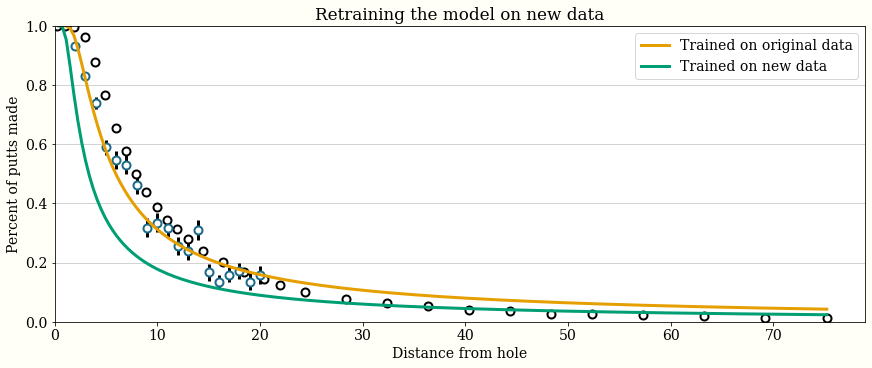

In [24]:
ax = plot_golf_data(new_golf_data)
plot_golf_data(golf_data, ax=ax)
t = np.linspace(0, new_golf_data.distance.max(), 200)

ax.plot(
    t,
    forward_angle_model(angle_trace["variance_of_shot"].mean(), t),
    label="Trained on original data",
)
ax.plot(
    t,
    forward_angle_model(new_angle_trace["variance_of_shot"].mean(), t),
    label="Trained on new data",
)
ax.set_title("Retraining the model on new data")
ax.legend();

モデルにもう少し工夫が必要。

角度だけのモデルだと長い距離のデータに対応できなくなるので、距離のばらつきもモデルに入れてみる

距離のばらつき→ゴルファーのパットの強さのばらつき　とも取れる

今回は、「ゴルファーはカップの1feet先を狙って打つ」と仮定

角度も距離も的確だった場合に「カップに入る」と定義


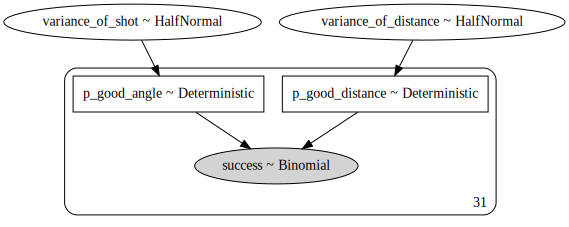

In [25]:
OVERSHOT = 1.0
DISTANCE_TOLERANCE = 3.0


def distance_angle_model(golf_data):
    distances = golf_data.distance.values
    with pm.Model() as distance_angle_model:
        variance_of_shot = pm.HalfNormal("variance_of_shot")
        variance_of_distance = pm.HalfNormal("variance_of_distance")
        p_good_angle = pm.Deterministic(
            "p_good_angle",
            2 * Phi(tt.arcsin((CUP_RADIUS - BALL_RADIUS) / distances) / variance_of_shot) - 1,
        )
        p_good_distance = pm.Deterministic(
            "p_good_distance",
            Phi((DISTANCE_TOLERANCE - OVERSHOT) / ((distances + OVERSHOT) * variance_of_distance))
            - Phi(-OVERSHOT / ((distances + OVERSHOT) * variance_of_distance)),
        )

        success = pm.Binomial(
            "success",
            n=golf_data.tries,
            p=p_good_angle * p_good_distance,
            observed=golf_data.successes,
        )
    return distance_angle_model


pm.model_to_graphviz(distance_angle_model(new_golf_data))

角度、距離のばらつきを考慮したモデルで再学習

In [26]:
with distance_angle_model(new_golf_data):
    distance_angle_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [variance_of_distance, variance_of_shot]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 657.90it/s]
The number of effective samples is smaller than 25% for some parameters.


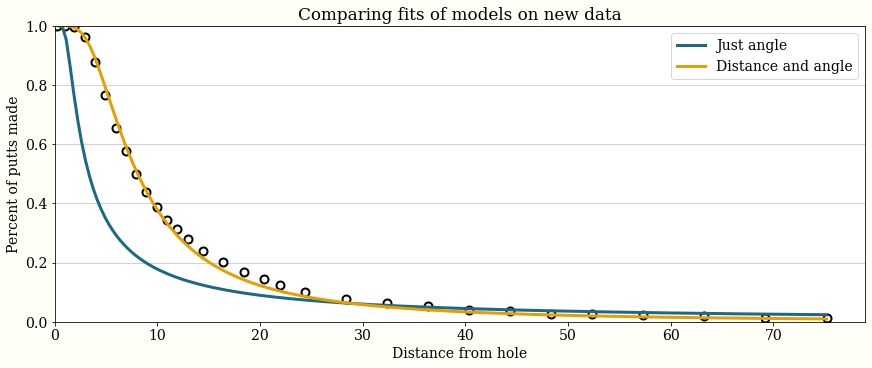

In [27]:
def forward_distance_angle_model(variance_of_shot, variance_of_distance, t):
    rv = st.norm(0, 1)
    angle_prob = 2 * rv.cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t) / variance_of_shot) - 1

    distance_prob_one = rv.cdf(
        (DISTANCE_TOLERANCE - OVERSHOT) / ((t + OVERSHOT) * variance_of_distance)
    )
    distance_prob_two = rv.cdf(-OVERSHOT / ((t + OVERSHOT) * variance_of_distance))
    distance_prob = distance_prob_one - distance_prob_two

    return angle_prob * distance_prob


ax = plot_golf_data(new_golf_data)
t = np.linspace(0, new_golf_data.distance.max(), 200)


ax.plot(t, forward_angle_model(new_angle_trace["variance_of_shot"].mean(), t), label="Just angle")
ax.plot(
    t,
    forward_distance_angle_model(
        distance_angle_trace["variance_of_shot"].mean(),
        distance_angle_trace["variance_of_distance"].mean(),
        t,
    ),
    label="Distance and angle",
)

ax.set_title("Comparing fits of models on new data")
ax.legend();